In [ ]:

!pip uninstall opencv-python-headless -y
!pip install opencv-python-headless==4.5.4.60 
!pip install easyocr

 # restart runtime
import os
os.kill(os.getpid(), 9)


     |████████████████████████████████| 47.6 MB 2.2 MB/s 
     |████████████████████████████████| 63.6 MB 49 kB/s 


In [1]:
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from imutils.perspective import four_point_transform

import easyocr

In [2]:
reader = easyocr.Reader(['en'], gpu= True)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


## Resize the image and set aspect ratio

In [3]:
url = "img_vernier/626519.jpg"
url ="https://raw.githubusercontent.com/Tuchsanai/Meter_Reader/main/Digital01/img_vernier/626519.jpg"
img = io.imread(url)




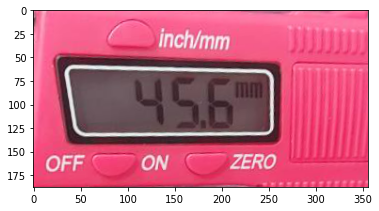

In [4]:
def find_Plastic_module_withColor_MAPPING(img):

    # define range of blue color in HSV
    low_red = np.array([168, 100, 220], dtype=np.uint8)
    high_red = np.array([175, 240,255], dtype=np.uint8)

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Threshold the HSV image to get only blue colors
    maskb = cv2.inRange(hsv, low_red, high_red)


    contour,hierarchy = cv2.findContours(maskb,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contour           = sorted(contour, key=cv2.contourArea, reverse=True)

    for c in  contour:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.05 * peri, True)
        if len(approx) == 4:
             four_points = np.squeeze(approx)
             imgx        = four_point_transform(img,four_points)
             return imgx
         
    return None




img2 = find_Plastic_module_withColor_MAPPING(img)

plt.imshow(img2)

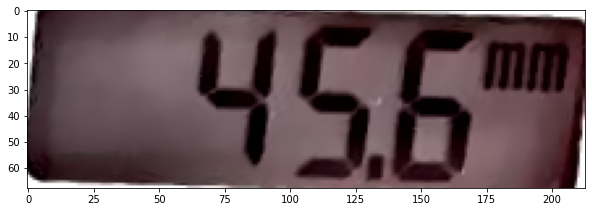

In [5]:
def FindLCD(img ,threshold = 180):
    # Grayscale and Canny Edges extracted
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    ret,th = cv2.threshold(blur,threshold,255,0)

    #plt.imshow(th)

    contour,hierarchy = cv2.findContours(th,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contour          = sorted(contour, key=cv2.contourArea, reverse=True)
    for contour in contour:
        peri = cv2.arcLength(contour,True)
        approx = cv2.approxPolyDP(contour,0.08*peri, True)
        
        if len(approx) == 4:
            four_points = np.squeeze(approx)
            imgx       = four_point_transform(img,four_points)
            imgx       = cv2.detailEnhance(imgx,sigma_s =25 , sigma_r = 0.3)
            imgx = cv2.bilateralFilter(imgx, 9, 27, 27)
            return imgx

    return None


lcd_img=FindLCD(img2)



plt.figure(figsize=(10,10))
plt.imshow(lcd_img)

In [8]:
bounds = reader.readtext( lcd_img )

print(bounds)

[([[54, 0], [180, 0], [180, 68], [54, 68]], '456', 0.9995587726640607)]


In [7]:
if len(bounds) >  0:
   str = bounds[0][1]
   print(str)

456
